# Feature Engineering

I'm going to outline a strategy similar to the fast.ai machine learning course. The general plan is to 
1. Build a simple, decent random forset model
2. Use this to understand which features are most imporatnt, focus on improving and expanding upon these features
3. Step back with improved features and try a set of models to find the best for this application
4. Tune hyperparamaters

First, though, I need a validation dataset. Since the goal is to predict into the future, I'll use the chronological end of my dataset for validation. If we take everything starting in 2017 and after, that will be ~15% of the total data

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

sns.set()
%matplotlib inline

In [4]:
data = pd.read_csv('sar_weather_df.csv')

validate = data[data.Year > 2016]
train = data[data.Year <= 2016]

print(train.shape, validate.shape)

(5461, 35) (820, 35)


In [5]:
print(train.columns)

# remove the date for RF training
train.drop('DATE', axis=1, inplace=True)
validate.drop('DATE', axis=1, inplace=True)

Index(['mission', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start', 'Elapsed', 'DATE', 'AWND_x', 'PRCP_x',
       'TAVG_x', 'TMAX_x', 'TMIN_x', 'TSUN', 'WT01', 'WT02', 'WT03', 'WT05',
       'WT08', 'WT10', 'AWND_y', 'PRCP_y', 'SNWD', 'TAVG_y', 'TMAX_y',
       'TMIN_y', 'TOBS', 'WESD'],
      dtype='object')


/home/afederation/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [6]:
y_train = train['mission']
X_train = train.drop('mission', axis=1)

y_validate = validate['mission']
X_validate = validate.drop('mission', axis=1)

In [17]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print(m.score(X_train, y_train))
print(m.score(X_validate, y_validate))
print(m.oob_score_)

0.8615638161508881
0.6682926829268293
0.7222120490752609


The build in scoring functions probably aren't ideal, since there's only a mission 29% of the time. First, I'll calculate precision and recall and compare to a naive model that always predicts the major class (0).

In [8]:
y_score = [x[1] for x in m.predict_proba(X_validate)]

In [9]:
print(roc_auc_score(y_validate,y_score)) # my model
print(roc_auc_score(y_validate, 0.29*np.ones(len(y_validate)))) # naive model


0.6215566389599319
0.5


                0           1
count  820.000000  820.000000
mean     0.658539    0.341461
std      0.113973    0.113973
min      0.327918    0.112250
25%      0.582460    0.249811
50%      0.672799    0.327201
75%      0.750189    0.417540
max      0.887750    0.672082


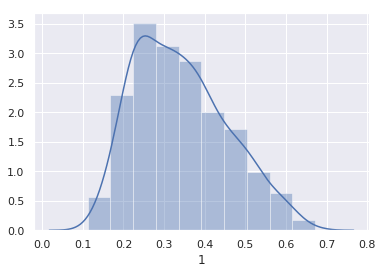

In [18]:
predictions = pd.DataFrame(m.predict_proba(X_validate))
sns.distplot(predictions[1], bins=10) #plot the prediction liklihood of a mission
print(predictions.describe())

Interesting. It's never more than 73% sure that a mission will happen. The negative predictive power is a bit better, getting as low as 12% liklihood. 

How can we improve our predictions? Add more features? Holidays? Google Data?

In [20]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, X_train); fi

,cols,imp
4,Dayofweek,0.089763
12,Elapsed,0.081817
5,Dayofyear,0.069390
16,TMAX_x,0.068863
13,AWND_x,0.068146
3,Day,0.063817
29,TMAX_y,0.060173
17,TMIN_x,0.056490
31,TOBS,0.055634
30,TMIN_y,0.053439


## Adding additional features

Two main categories 
- Holiday data
- Google Trends